 Importar dependencias
 

In [37]:
# Librerías base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA             
from sklearn.discriminant_analysis import StandardScaler




In [38]:

# ========================
# 1. Cargar datos desde un CSV limpio
# ========================
df = pd.read_csv("luminarias_limpias.csv")

# Mostrar las primeras filas para validar la carga
df.head()

,tipo,potencia_watts,altura_metros,estado,sensores_luminosidad_lux,sensores_movimiento,sensores_temperatura_c,sensores_humedad_pct,eficiencia_lumens_por_watt,eficiencia_vida_util_restante_pct,registro_fecha_instalacion
0,Halógena,150,6.56,Fallando,101,True,23.6,59.4,100.87,82.9,2024-11-18
1,Incandescente,75,6.89,Encendida,125,False,34.8,50.0,96.66,50.9,2024-01-20
2,Halógena,150,7.47,Encendida,156,True,25.3,64.2,115.65,53.3,2025-04-16
3,Halógena,75,8.47,Apagada,179,False,27.8,52.8,113.91,38.0,2025-03-20
4,Halógena,100,8.84,Apagada,248,False,29.6,40.6,118.38,77.7,2024-11-29


In [39]:
# ========================
# 2. Selección de features
# ========================
features = [
    "potencia_watts",
    "altura_metros",
    "sensores_luminosidad_lux",
    "sensores_movimiento",
    "sensores_temperatura_c",
    "sensores_humedad_pct",
    "eficiencia_lumens_por_watt",
    "eficiencia_vida_util_restante_pct"
]

X = df[features]
y = df["estado"]

# ========================
# 3. Codificar etiquetas
# ========================
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# ========================
# 4. Escalado
# ========================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ========================
# 5. Train/Test Split
# ========================
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.3, random_state=42
)

# ========================
# 6. Modelo
# ========================
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ========================
# 7. Evaluación
# ========================
y_pred_test = model.predict(X_test)

print("Reporte de Clasificación:\n", classification_report(y_test, y_pred_test, target_names=le.classes_))
print("\nMatriz de Confusión:\n", confusion_matrix(y_test, y_pred_test))

# ========================
# 8. Predicciones para todo el DataFrame
# ========================
df['prediccion_estado'] = le.inverse_transform(model.predict(X_scaled))

Reporte de Clasificación:
               precision    recall  f1-score   support

     Apagada       0.34      0.17      0.23      2278
   Encendida       0.47      0.82      0.60      3157
    Fallando       0.19      0.01      0.02      1239

    accuracy                           0.45      6674
   macro avg       0.34      0.33      0.28      6674
weighted avg       0.38      0.45      0.37      6674


Matriz de Confusión:
 [[ 394 1865   19]
 [ 530 2588   39]
 [ 228  997   14]]


# Graficos


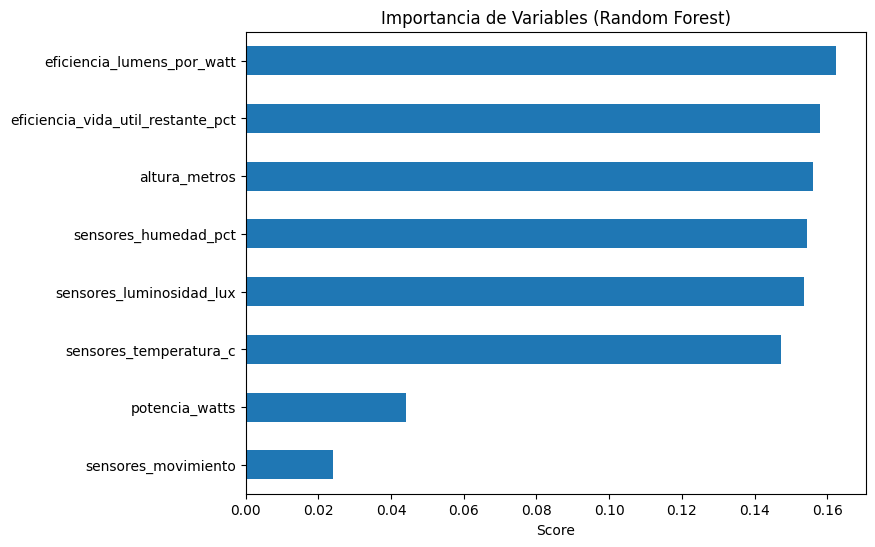

In [40]:
#1. Importancia de Variables

importances = model.feature_importances_
feat_importances = pd.Series(importances, index=features).sort_values(ascending=True)

plt.figure(figsize=(8,6))
feat_importances.plot(kind='barh')
plt.title("Importancia de Variables (Random Forest)")
plt.xlabel("Score")
plt.show()


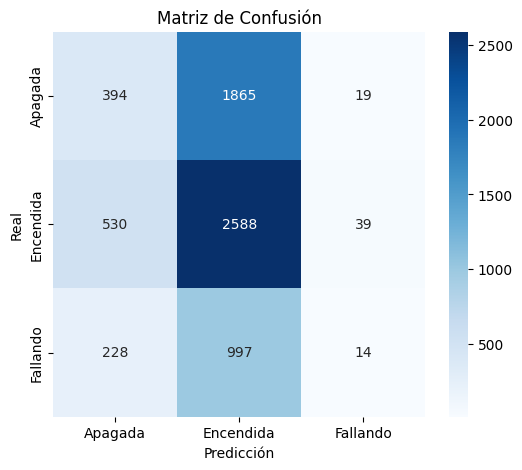

In [41]:
#2. Matriz de Confusión
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues", 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matriz de Confusión")
plt.ylabel("Real")
plt.xlabel("Predicción")
plt.show()


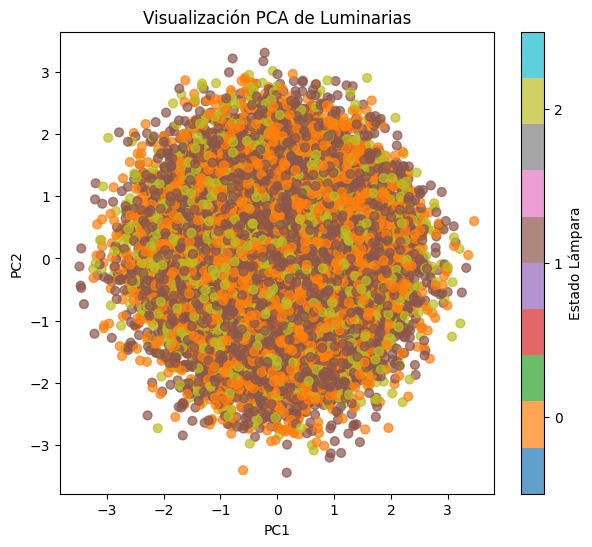

In [42]:
# Reducción de dimensionalidad
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Convertir etiquetas a números para colores
y_numeric = le.transform(df['estado'])  # o usar y_encoded si ya lo tienes

# Gráfico PCA
plt.figure(figsize=(7,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=y_numeric, cmap='tab10', s=40, alpha=0.7)
plt.title("Visualización PCA de Luminarias")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter, ticks=range(len(le.classes_)), label="Estado Lámpara")
plt.clim(-0.5, len(le.classes_)-0.5)  # para alinear colores con ticks
plt.show()

In [43]:

# ========================
# 9. Exportar JSON por estado
# ========================
for estado in df['prediccion_estado'].unique():
    filename = f"luminarias_{estado.lower()}.json"
    df[df['prediccion_estado'] == estado].to_json(filename, orient="records")